In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from histogram_filters import convolve
from kalman import plot_gaussian
from kalman import plot_kalman_process

# Kalman filter


- Continuous Gaussian linear markov filter
- Parametric filter with parameters: $\mu$, $\sigma^2$
- Unimodal
- Google uses it to locate other cars

# The model (Moving object)
## Definition

$S_k = S_{k-1} + 1 + W$

$X_k = S_k + V$

Similar to the [additive noise histogram filter](https://github.com/jganzabal/Kalman-as-Recursive-Bayesian-Estimation/blob/master/Additive%20noise%20Histogram%20Filters.ipynb)  but with some fundamental differences:
- $S_k$ is a continuos process. No more discrete states
- $W_n$ is Gaussian
- $V$ is Gaussian

Instead of having probabilities, we have densities. We use lowercase p is density, uppercase P for probability

**Moving noise** (W):

$p(W) = N(0,\sigma_w^2) = \Large{\frac{1}{\sigma_w \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(W)}{\sigma_w^2}^2}}$

$\mu_w = 0$

**Measurement error**:

$p(V) = N(0,\sigma_v^2) = \Large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(V)}{\sigma_v^2}^2}}$

$\mu_v = 0$

## The observation  - $X_k = S_k + V$
This is the density before observing given than we are on a specific state

V is gaussian with mean 0, so $X_k$ given $S_k$ will be gaussian with mean $S_k$. 

$p(X_k|S_k) = N(S_k,\sigma_v^2) = \Large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(X_k-S_k)}{\sigma_v^2}^2}}$


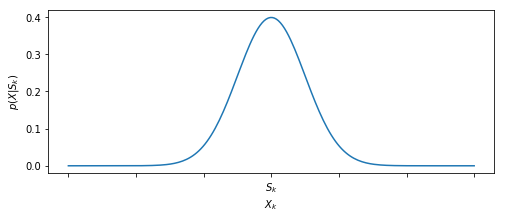

In [5]:
_ =plot_gaussian(N = 6, y_label = "$p(X|S_k)$", x_label = "$X_k$", center_label_tick = "$S_k$",figsize=(8,3))

## The likelihood -  $\mathcal{L}(S_k|X_k)$ = $p(X_k|S_k)$ 

Remember that for the likelihood, the observation $X_0$ is fixed and $S_k$ varies

$p(X=X_k|S_k) = N(S_k,\sigma_v^2) = \Large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(X_k-S_k)}{\sigma_v^2}^2}}$

This is equivalent to a Gaussian pdf that depends on $S_k$ with mean $X_0$ and variance $\sigma_v$

So given the observation $X_0$ the likelihood is:

$p(S_k| \mu=X_k) = N(X_k,\sigma_v^2) = \Large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(S_k-X_k)}{\sigma_v^2}^2}}$

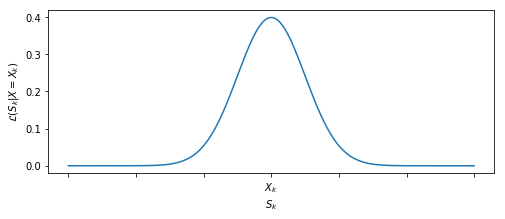

In [4]:
_ =plot_gaussian(N = 6, y_label = "$\mathcal{L}(S_k|X=X_k)$", x_label = "$S_k$", center_label_tick = "$X_k$",figsize=(8,3))

## Prior (belief): my belief before measuring

$p(S_0) = N(\mu_{s_0}, \sigma_{s_0}^2) = \Large{\frac{1}{\sigma_{s_0} \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(S-\mu_{s_0})}{\sigma_{s_0}^2}^2}}$

$\sigma_{s_0}^2$ is the initial uncertainty. Usually larger than $\sigma_w^2$ and $\sigma_v^2$

$\mu_{s_0}$ is the initial position. Usually zero

## Posterior: probability of a state given the measurements


$\large{p(S_k|X_k) = \alpha p(X_k|S_k)p(S_K)}$

**Bayes**:

$\large{p(S_k|X_k) = \frac{p(X_k|S_k)p(S_K)}{p(X_k)}}$

$p(X_k) = \sum_i{p(X_k,S_i)} = \sum_i{p(X_k|S_i)p(S_i)}$

Because likelihood and prior are gaussians, the posterior is gaussian

# The filter
## The goal. Where am I?
Find my position $S_k$ given the observations
## Update - Bayes
Given the prior and the likelihood, find the posterior $S_k$

$X_k = S_k + V$

## Predict - Sum of random variable
With the posterior predict $S_k$ adding 1 + W

$S_k = S_{k-1} + 1 + W$

## Loop
My prediction is my prior, so observe X again and update, and so on ...

# Properties of the gaussians - Parametric model

https://github.com/jganzabal/Kalman-as-Recursive-Bayesian-Estimation/blob/master/pdfs/gaussians_convolutions_lecture3.pdf

## Update - Product of Gaussians pdfs

The product of 2 Gaussians pdfs with parameters $\mu_u$, $\sigma_u^2$ and $\mu_{v}$,$\sigma_{v}^2$ is proportional to a Gaussian with parameters $\mu_{x}$,$\sigma_{x}^2$ calculated as follows

$p(X) = \alpha p(U)p(V)$

$\mu_{x} = \Large{\frac{\sigma_u^2\mu_v +\mu_u \sigma_v^2}{\sigma_u^2 + \sigma_v^2}}$

Parallel resistances analogy

$\sigma_{x}^2 = \Large{\frac{\sigma_u^2 \sigma_v^2}{\sigma_u^2 + \sigma_v^2}}$


### Implementation

In [112]:
def update(mean1, var1, mean2, var2):
    new_mean = float(var2 * mean1 + var1 * mean2) / (var1 + var2)
    new_var = 1./(1./var1 + 1./var2)
    return [new_mean, new_var]

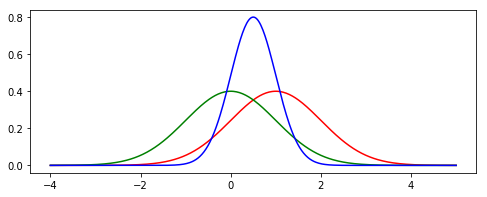

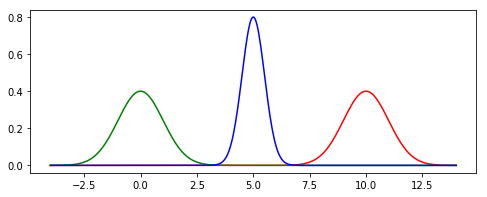

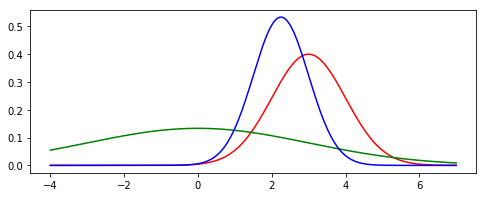

In [146]:
def plot_product(mu_u, sig_u, mu_v, sig_v, points=400):
    f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = (8,3))
    N = 4
    x = np.linspace(min(mu_u,mu_v)-N*sig_u, max(mu_u,mu_v)+N*sig_u, points)
    
    _, prior =plot_gaussian(mu = mu_u, sig = sig_u, N = 6, ax = ax, x=x, color = 'r')
    _, likelihood =plot_gaussian(mu = mu_v, sig = sig_v, ax = ax, x=x, color = 'g')

    mu_y, sig_y = update(mu_u, sig_u, mu_v, sig_v)

    _ = plot_gaussian(mu = mu_y, sig = sig_y, N = 6, ax = ax, x=x, color = 'b')
    plt.show()
    
sig_u = 1; sig_v = 1; mu_u = 1; mu_v = 0
plot_product(mu_u, sig_u, mu_v, sig_v)
sig_u = 1; sig_v = 1; mu_u = 10; mu_v = 0
plot_product(mu_u, sig_u, mu_v, sig_v)
sig_u = 1; sig_v = 3; mu_u = 3; mu_v = 0
plot_product(mu_u, sig_u, mu_v, sig_v)

### Conclusions
- The variance of the product of 2 pdfs is always less than the minimum of both.
- The product of 2 pdfs is not the same as the product of 2 random variables
- The update always lowers the uncertainty

### Applied to the model

$\large{p(S_k|X_k) = \alpha p(X_k|S_k)p(S_K)}$

$\large{N(\mu_{s_{k}}, \sigma_{s_{k}}^2)  = \alpha N(X_k,\sigma_v^2)N(\mu_{s_{k}}, \sigma_{s_{k}}^2)}$

$\mu_{s_{k}} = \Large{\frac{\sigma_{v}^2\mu_{s_k} +\mu_{X_k} \sigma_{s_k}^2}{\sigma_{v}^2 + \sigma_{s_k}^2}}$

Parallel resistances analogy

$\sigma_{s_{k}}^2 = \Large{\frac{\sigma_{s_{k}}^2 \sigma_v^2}{\sigma_{s_{k}}^2 + \sigma_v^2}}$

## Predict - Convolution of Gaussians

The sum of random variables is equal to a gaussian where the mean and the variances are the sum of the mean and variances respectevely

$X = U + V$

$\mu_{X} = \mu_{U} +\mu_V$

$\sigma_{X}^2 = \sigma_{U}^2 +\sigma_V^2$

### Implementation

In [10]:
def predict(mean1, var1, mean2, var2):
    new_mean = mean1 + mean2
    new_var = var1 + var2
    return [new_mean, new_var]

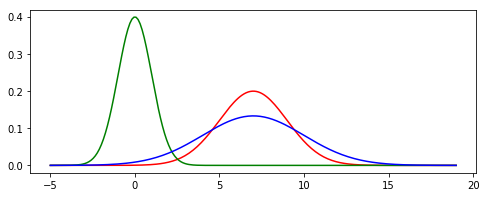

In [11]:
f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = (8,3))
mu_s = 7
sig_s = 2
mu_w = 0
sig_w = 1
x, posterior = plot_gaussian(mu = mu_s, sig = sig_s, N = 6, ax = ax, color = 'r')
W = plot_gaussian(mu = mu_w, sig = sig_w, N = 6, ax = ax, x=x, color = 'g')

mu_p, sig_p = predict(mu_s,sig_s, mu_w,sig_w)

W = plot_gaussian(mu = mu_p, sig = sig_p, N = 6, ax = ax, x=x, color = 'b')
plt.show()

### Applied to the model:


$S_{k+1} = S_{k} + 1 + W$

$\mu_W = 0$

$\mu_{s_{k+1}} = \mu_{s_k} +\mu_w + 1 = \mu_{s_k} + 1$

$\sigma_{s_{k+1}}^2 = \sigma_{s_k}^2 +\sigma_w^2$


# Generative model

# Examples

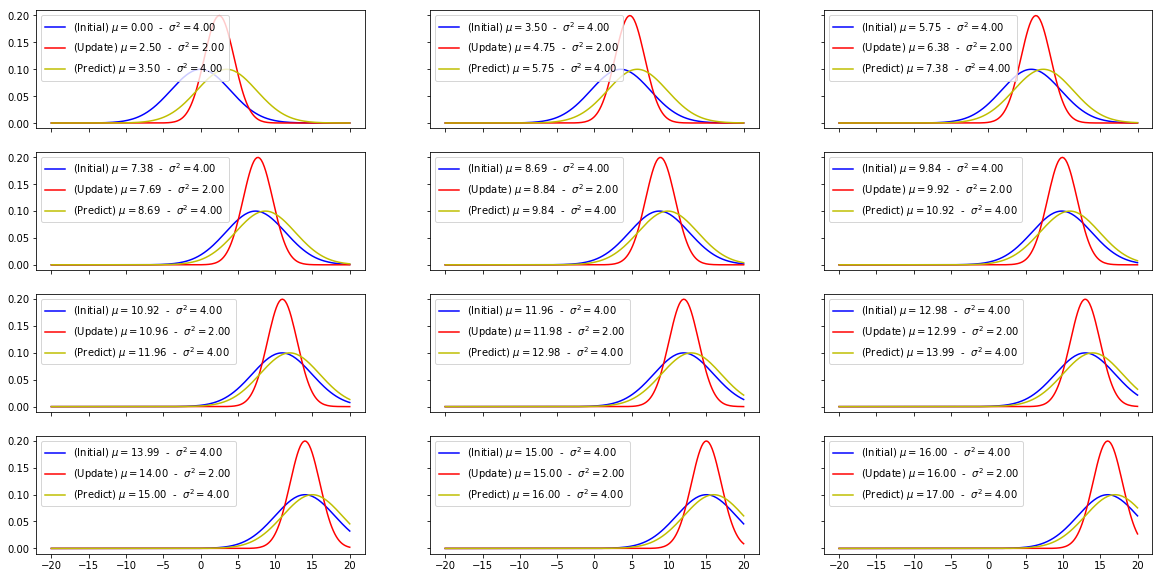

In [161]:
first = 5
last = 16
measurements = list(np.linspace(first,last,last-first+1))
motion = list(np.ones(len(measurements)))

# Variance of measurement
measurement_sig = 4.
# Variance of action
motion_sig = 2.
# Initial mu
mu = 0.
# Initial variance
sig = 4.
points = 200
plot_kalman_process(mu, sig, measurement_sig, motion_sig, points, measurements, motion)

# Updating and predicting in one step
Notation change. $k = n$

$\mu_w = 0$

$\mu_{s_{k}} = \Large{\frac{\sigma_{v}^2\mu_{s_k} +\mu_{X_k} \sigma_{s_k}^2}{\sigma_{v}^2 + \sigma_{s_k}^2}}$

$\sigma_{s_{k}}^2 = \Large{\frac{\sigma_{s_{k}}^2 \sigma_v^2}{\sigma_{s_{k}}^2 + \sigma_v^2}}$

$\mu_{s_{k+1}} = \mu_{s_k} + 1$

$\sigma_{s_{k+1}}^2 = \sigma_{s_k}^2 +\sigma_w^2$

Replacing

$\mu_{s_{k+1}} = \large{\frac{\sigma_{v}^2\mu_{s_k} +\mu_{X_k} \sigma_{s_k}^2}{\sigma_{v}^2 + \sigma_{s_k}^2}} + 1$

$\sigma_{s_{k+1}}^2 = \large{\frac{\sigma_{s_{k}}^2 \sigma_v^2}{\sigma_{s_{k}}^2 + \sigma_v^2}} +\sigma_w^2$

# Traditional equations

$S_n = a_nS_{n-1} + bU_n + W$

$X_n = S_n + V$

$P_1$ = $\sigma_s^2$ prior


$\hat{S_1}$ = $\mu_s$ prior

$K_n = \frac{P_n}{P_n+\sigma_v^2}$

$\hat{S_{n+1}} = a_{n+1}[\hat{S_n} + K_k(X_n - \hat{S_n})] + bU_n$

$P_{n+1} = a^2_{n+1}[1-K_n]P_n + \sigma_w^2$

$n = n + 1$

## How do the two models relate?

$K_n = \frac{P_n}{P_n+\sigma_v^2}$

$P_{n+1} = a^2_{n+1}[1-K_n]P_n + \sigma_w^2$

Replacing the first ecuacion into the second one and $a_{n+1} = 1$ :

$P_{n+1} = [\frac{\sigma_v^2}{P_n + \sigma_v^2}]P_n + \sigma_w^2$

First term of the sum is the update, second term is the prediction


# Asyntotic behavior

In [ ]:

# measurement
sig_v = measurement_sig
# Variance of action
sig_w = motion_sig
a = 1
P_pred = (sig_w + sig_v*(a**2-1) +  np.sqrt((sig_w + sig_v*(a**2-1))**2 + 4*sig_w*sig_v))/2
P_obs = P_pred - sig_w
K = P_pred/(P_pred + sig_v)
p_n1 = (1-K)*P_pred + sig_w
print(P_pred, P_obs, K, p_n1)